<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/Titanic_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2900","key":"2507a7e3dd9a47a3b2ffc26308eaa233"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Jun  5 02:21 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
vjchoudhary7/customer-segmentation-tutorial-in-python        Mall Customer Segmentation Data                       2KB  2018-08-11 07:23:02          15309  
fivethirtyeight/fivethirtyeight-comic-characters-dataset     FiveThirtyEight Comic Characters Dataset            577KB  2019-04-26 15:01:41           4678  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          40077  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          38084  
iarunava/cell-images-for-detecting-malaria                

In [6]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 23.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 29.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.00MB/s]


In [264]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender =  pd.read_csv('gender_submission.csv')

X = training.drop('Survived',axis = 1 )
y_train = training.Survived
#drop name + pass id
feature_train = X.drop(['Name','PassengerId'],axis = 1)
feature_test = test.drop(['Name','PassengerId'],axis = 1)
# chuan hoa SEX
gioitinh= {'male':0,'female':1}
feature_train.Sex.replace(gioitinh,inplace = True)
feature_test.Sex.replace(gioitinh,inplace = True)
# chuan hoa embarked
embarked = {'S':1,'C':2,'Q':3}
feature_train.Embarked.replace(embarked,inplace = True)
feature_train.Embarked.fillna(0,inplace = True)

feature_test.Embarked.replace(embarked,inplace = True)
feature_test.Embarked.fillna(0,inplace = True)
# chuan hoa family =  Sibsp + parch
feature_train['Family'] = feature_train.SibSp  + feature_train.Parch
feature_train.Family.loc[feature_train.Family > 0] =1 
feature_train.Family.loc[feature_train.Family == 0] = 0 

feature_test['Family'] = feature_train.SibSp  + feature_train.Parch
feature_test.Family.loc[feature_train.Family > 0] =1 
feature_test.Family.loc[feature_train.Family == 0] = 0 
#chuan hoa AGE
feature_train.Age.fillna(0,inplace = True)
feature_test.Age.fillna(0,inplace = True)

feature_train.Cabin.fillna("X",inplace = True)
feature_train.Cabin = [i[0] for i in feature_train.Cabin]
s = feature_train.Cabin.sort_values().unique()
label = pd.factorize(s)
feature_train.Cabin = feature_train.Cabin.replace(label[1],label[0])

X_train = feature_train.drop(['Ticket','SibSp','Parch'],axis= 1)
 
print(feature_train.shape, feature_test.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(891, 10) (418, 10)


In [223]:
print(X_train.shape,y_train.shape)

(891, 7) (891,)


In [0]:
combine = [feature_train,feature_test]

In [0]:
feature_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,3,0,22.0,1,0,A/5 21171,7.2500,8,1.0,1
1,1,1,38.0,1,0,PC 17599,71.2833,2,2.0,1
2,3,1,26.0,0,0,STON/O2. 3101282,7.9250,8,1.0,0
3,1,1,35.0,1,0,113803,53.1000,2,1.0,1
4,3,0,35.0,0,0,373450,8.0500,8,1.0,0


In [11]:
training[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived',ascending= False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
training[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived',ascending= False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
training[['SibSp', 'Survived']].groupby(['SibSp'], as_index = False).mean().sort_values(by = 'Survived',ascending= False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [14]:
training[['Parch', 'Survived']].groupby(['Parch'], as_index = False).mean().sort_values(by = 'Survived',ascending= False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


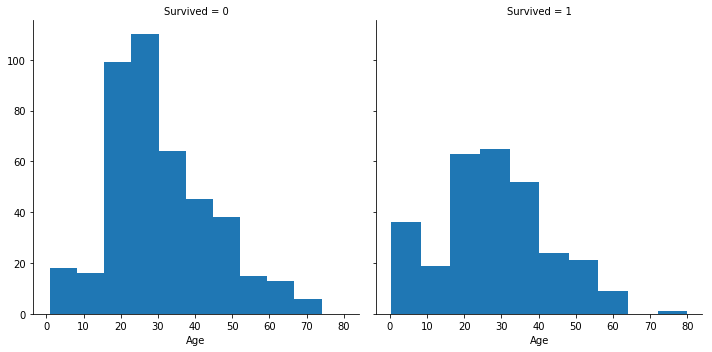

In [17]:
sns.FacetGrid(data= training, col = 'Survived',size = 5).map(plt.hist,'Age')

In [87]:
training.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


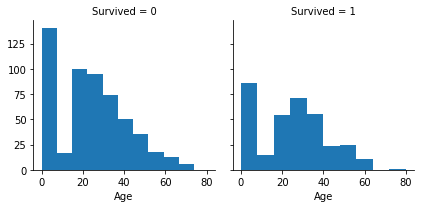

In [49]:
g = sns.FacetGrid(data= training, col = "Survived")
g = g.map(plt.hist,'Age')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


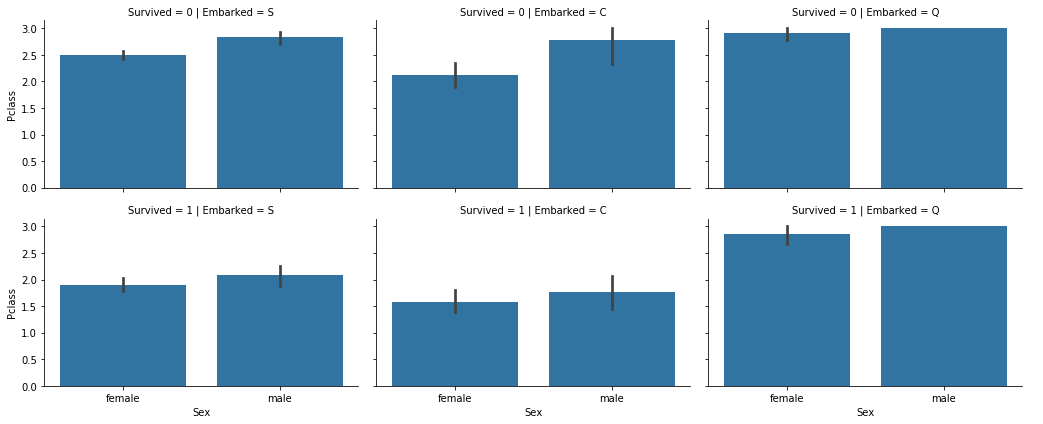

In [108]:
grid = sns.FacetGrid(training, col='Embarked', row = "Survived", size=3, aspect=1.6)
grid.map(sns.barplot,  'Sex','Pclass',)
grid.add_legend()


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


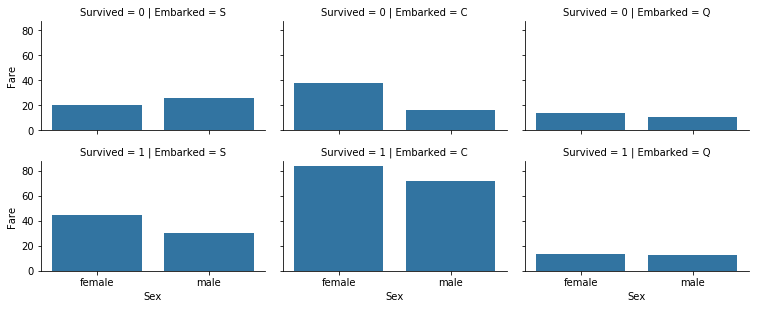

In [111]:
grid = sns.FacetGrid(training, col='Embarked',row = 'Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex','Fare',ci = None)
grid.add_legend()

In [112]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


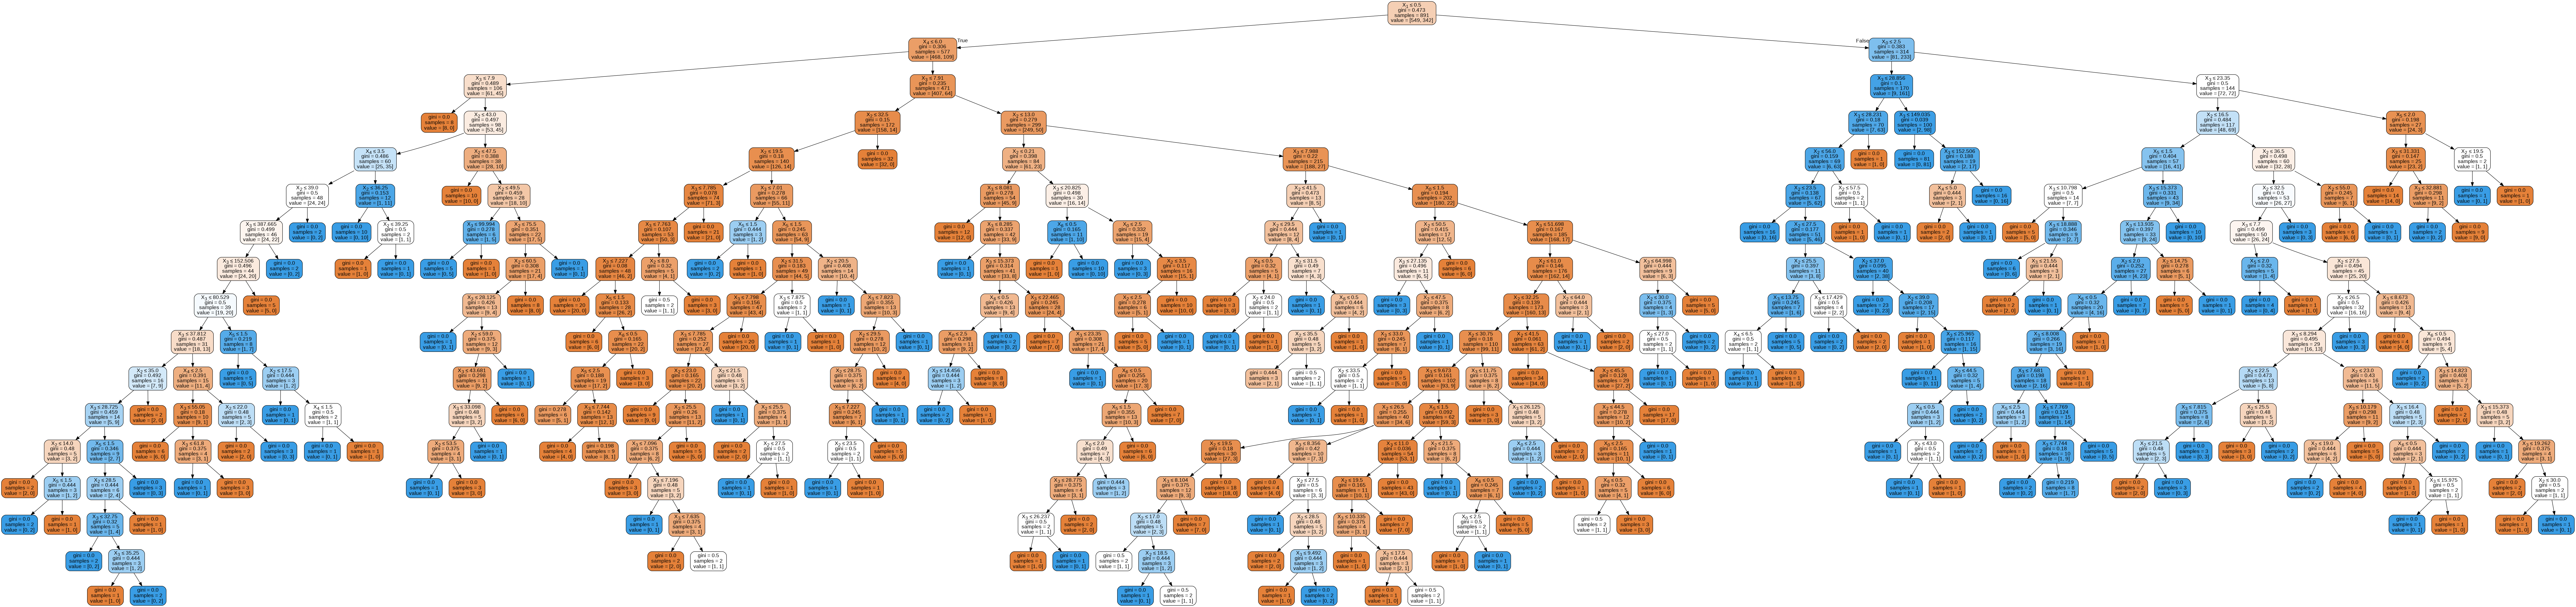

In [113]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
# edit dataset
guess_ages = np.zeros((2,3))
for dataset in combine:
  for i in range(0,2):
    for j in range(0,3):
        guess_df = dataset[(dataset['Sex'] == i) &(dataset['Pclass'] == j+1)]['Age'].dropna()
        age_guess = guess_df.median()
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
  for i in range(0,2):
    for j in range(0,3):
      dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]
    dataset['Age'] = dataset['Age'].astype(int)

pandas.core.frame.DataFrame

ValueError: ignored

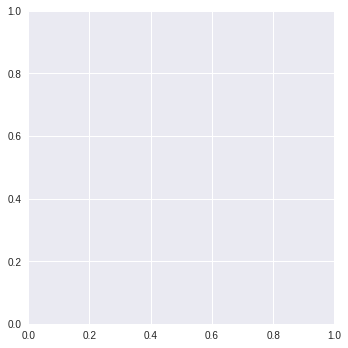

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.FacetGrid(X, hue = 'Survived', size = 5).map(plt.hist,'Fare','Age').add_legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  cat_pos = np.ones(swarm_data.size) * center


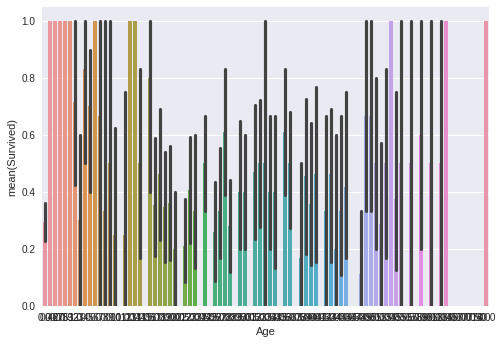

In [0]:
sns.barplot("Age","Survived", data = X)

In [216]:
test.head()
X_test = test
feature_test = X_test.drop(['Name','PassengerId'],axis = 1)

gioitinh= {'male':0,'female':1}
feature_test.Sex.replace(gioitinh,inplace = True)

embarked = {'S':0,'C':1,'Q':2}
feature_test.Embarked.replace(embarked,inplace= True)


feature_test['Family'] = feature_test.SibSp  + feature_train.Parch
feature_test.Family.loc[feature_test.Family > 0] =1 
feature_test.Family.loc[feature_test.Family == 0] = 0 

feature_test.Age.fillna(0,inplace = True)

feature_test.Cabin.fillna('X',inplace = True)
feature_test.Cabin = [i[0] for i in feature_test.Cabin]
h = feature_test.Cabin.sort_values().unique()
label = pd.factorize(h)
feature_test.Cabin = feature_test.Cabin.replace(label[1],label[0])

feature_test.Fare.fillna(0,inplace = True)
feature_test = feature_test.drop(['SibSp','Parch','Ticket'],axis = 1 )
X_test = feature_test
y_test = gender.Survived

test.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [290]:
X_test.shape

(418, 7)

In [0]:
X_train, X_val,y_train, y_val = train_test_split(X_train,y_train)

In [225]:
y_train.shape

(668,)

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import cross_validate
print(X_train.shape)
print(y_train.shape)

model = LogisticRegression()
model.fit(X_train,y_train)
print(model.coef_)
pred = model.predict(X_test)
print(pred.shape)
loss = mean_squared_error(y_test,pred)
print('Mean Squared Error: ', loss)
score = r2_score(y_test,pred)
print(f'Variabel accuracy: {score}')
vals = cross_validate(model,X_val,y_val, cv = 5)


(891, 7)
(891,)
[[-8.55763512e-01  2.49028459e+00 -1.26790121e-02  3.93423119e-04
  -7.61999739e-02  2.27144778e-01  1.05382434e-01]]
(418,)
Mean Squared Error:  0.023923444976076555
Variabel accuracy: 0.8966165413533834


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [0]:
a = y_train.reshape(-1,1)
a.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


(668, 1)

In [206]:
!pip install data_utils

  ERROR: Could not find a version that satisfies the requirement data_utils (from versions: none)
ERROR: No matching distribution found for data_utils


In [322]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F
dtype = torch.float
device = torch.device("cpu")



trainX = X_train.values
trainY = y_train.values

x = torch.Tensor(trainX, device=device)
y = torch.Tensor(trainY, device = device)

N , D_in, H, D_out =  64 , X.shape[0], 100, 1
print(N , D_in, H, D_out)

w1 = torch.randn(D_in , H,device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)


learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

64 7 100 1
0 264804171776.0


RuntimeError: ignored

In [326]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
N = 100
D = 2

X = np.random.randn(N,D)*2
X[:N/2,:] = X[:N/2,:] - 2*np.ones((N/2,D))

# center the last N/2 points at (2, 2)
X[N/2:,:] = X[N/2:,:] + 2*np.ones((N/2,D))

# labels: first N/2 are 0, last N/2 are 1
T = np.array([0]*(N/2) + [1]*(N/2)).reshape(100,1)

x_data = Variable(torch.Tensor(X))
y_data = Variable(torch.Tensor(T))

TypeError: ignored

In [0]:
train_y

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


train_loader = torch.utils.data.DataLoader(dataset=X_train, 
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset= X_test,
                                          batch_size=100, 
                                          shuffle=False)

input_size = x.shape[0]
num_class = 7

In [0]:
class Logistic(torch.nn.Module):
  def __init__(self,input_size, num_class):
    super(Logistic,self).__init__()
    self.linear = nn.Linear(input_size,num_class)
  
  def forward(self):
    out = self.linear(x)
    return out
model = Logistic(input_size, num_class)


In [0]:
for epoch in range(num_epochs):
  
      

In [300]:
for index, value in enumerate(train_loader):
  print(value)

KeyError: ignored